In [4]:
pip install 'aif360[LawSchoolGPA]'

  Obtaining dependency information for pytest from https://files.pythonhosted.org/packages/df/d0/e192c4275aecabf74faa1aacd75ef700091913236ec78b1a98f62a2412ee/pytest-7.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/b8/d8/15066ae71ba63683b8e53a8bef0e75bd87e95b79ef293f63fa674b351d9b/shap-0.42.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pluggy<2.0,>=0.12 from https://files.pythonhosted.org/packages/51/32/4a79112b8b87b21450b066e102d6608907f4c885ed7b04c3fdb085d4d6ae/pluggy-1.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for exceptiongroup>=1.0.0rc8 from https://files.pythonhosted.org/packages/ad/83/b71e58666f156a39fb29417e4c8ca4bc7400c0dd4ed9e8842ab54dc8c344/exceptiongroup-1.1.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━

In [333]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import statsmodels.api as sm

import seaborn as sns

# sklearn

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, recall_score, precision_score, f1_score, roc_auc_score, roc_curve


# aif360

from aif360.sklearn.datasets import fetch_german
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset, StandardDataset


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [334]:
df = pd.read_csv('adult_data.csv')
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K


## 1. Introducción

Se tiene una base datos que contiene datos sociodemográficos y financieros de 45222 personas como edad, nivel educativo, estado civil, sexo, ingresos, ganancias de capital, etc, proveniente de "adult dataset" disponible en [AIF360](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.datasets.AdultDataset.html#aif360.datasets.AdultDataset). se aplica un modelo de regresión logística binaria para clasificar las personas segun los ingresos en menores/iguales o mayores a 50.000 dólares. Las personas clasificadas en ingresos mayores 50.000 dólares tiene prioridad en el acceso a crédito de vivienda.

## 2. Objetivos

2.1 Determinar las variables explicativas de clasificación de las personas por ingresos.

2.2 Aplicar el modelo de regresión logística binaria para agrupar las personas segun ingresos.

2.3 Establecer si el modelo de regresión logística esta sesgado por sexo, es decir, se favorece el etiquetado de las personas en ingresos altos si son hombres o mujeres, utilizando las métricas de Fairness. 

2.4 Aplicar el Algoritmo EqOddsPostProcessing para que el modelo clasificador trate a hombres y mujeres con las mismas tasas de error de clasificación.

## 3. Resultados

### 3.1 Análisis exploratorio

De acuerdo a las medias y las desviaciones estandar de las variables agrupadas por ingresos (income) anuales, las distribuciones de las variables age (edad), education-num (numero de niveles educativos), capital-loss (pérdida de capital), hours-per-week (horas laborales por semana) de los dos grupos de ingresos (<=50K y >50k) se traslapan totalmente, por lo tanto no contribuyen a discriminar entre los dos grupos de ingresos de interés. La única variable que que potencialmente aportaría al establecimiento de diferencias entre los grupos de ingresos es capital-gain (ingresos de capital) ya que el traslape es parcial pero representativo porque sus desviaciones son amplias.

In [6]:
#Variables cuantitativas

In [335]:
#Media 
df_mean= df.groupby('income').agg({'age': ['mean'], 'education-num': ['mean'],'capital-gain':['mean'],
                                   'capital-loss':['mean'],'hours-per-week':['mean']})
df_mean.columns = ['age','education-num', 'capital-gain','capital-loss','hours-per-week']
df_mean

,age,education-num,capital-gain,capital-loss,hours-per-week
income,,,,,
<=50K,36.749427,9.630770,149.023402,54.032428,39.372023
>50K,44.006067,11.598501,3991.791667,193.487063,45.690489


In [4]:
#Desviación estándar

In [336]:
df_std= df.groupby('income').agg({'age': ['std'], 'education-num': ['std'],'capital-gain':['std'],
                                  'capital-loss':['std'],'hours-per-week':['std']})
df_std.columns = ['age','education-num', 'capital-gain','capital-loss','hours-per-week']
df_std

,age,education-num,capital-gain,capital-loss,hours-per-week
income,,,,,
<=50K,13.564683,2.420402,927.447387,312.220461,11.974127
>50K,10.340502,2.367451,14616.543746,592.642319,10.797764


Nota: No es posible visualizar en este Notebook los gráficas con seaborn.
sns.histplot(x = "age", hue = "income", data = df)
sns.histplot(x = "education-num", hue = "income", data = df)
sns.histplot(x = "capital-gain", hue = "income", data = df)
sns.histplot(x = "capital-loss", hue = "income", data = df)
sns.histplot(x = "hours-per-week", hue = "income", data = df)

In [337]:
#Normalizar la variable capital-gain
from scipy import stats
matriz_capital_gain = stats.zscore(df['capital-gain'])

#volver la matriz un dataframe
df_capital_gain=pd.DataFrame(matriz_capital_gain)

#Unir df_capital_gain a df
df1=pd.concat([df, df_capital_gain], axis=1)

In [330]:
df1.drop(['capital-gain'], axis=1, inplace=True)

In [338]:
#renombrar variable
df1.rename(columns={0:'capital_gain'},inplace=True)    

In [339]:
df1.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,capital_gain
0,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K,-0.146733
1,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,-0.146733
2,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K,-0.146733
3,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K,0.877467
4,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K,-0.146733


De las variables categóricas, de acuerdo a las variaciones de sus distribuciones segmentadas por income. Las variables que permiten encontrar diferencias entre los dos grupos de ingresos son education, marital_status, occupation y sex. Se excluye a relationship porque esta correlacionado con el compartamiento de marital_status. La variable race no se contempla porque no se observa que las distribuciones sean significativamente diferentes en los grupos de ingresos.

In [ ]:
#Variables cualitativas

In [340]:
#workclass
crostab_workclass=pd.crosstab(values=df['age'], columns=df['income'], index=df['workclass'], 
                  aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_workclass

income,<=50K,>50K
workclass,,
Private,76.603751,64.694861
Self-emp-not-inc,8.046687,9.448608
Local-gov,6.423825,8.163812
Self-emp-inc,2.157935,8.137045
Federal-gov,2.519551,4.898287
State-gov,4.192391,4.639543
Without-pay,0.055859,0.017844


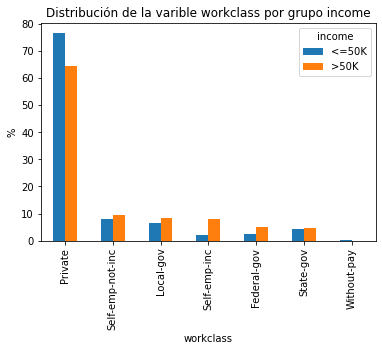

In [341]:
crostab_workclass.plot(kind='bar')
plt.xlabel('workclass')
plt.ylabel('%')
plt.title('Distribución de la varible workclass por grupo income')
plt.show()

In [342]:
#education
crostab_education=pd.crosstab(values=df['age'], columns=df['income'], index=df['education'], 
                              aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100

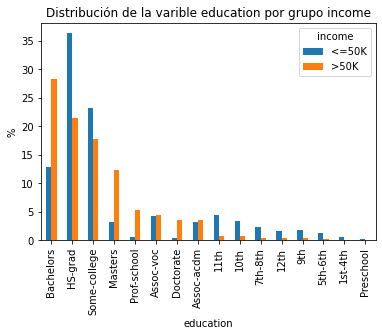

In [343]:
crostab_education.plot(kind='bar')
plt.xlabel('education')
plt.ylabel('%')
plt.title('Distribución de la variable education por grupo income')
plt.show()

In [344]:
#Reagrupar categorías
df1['education'] = df1['education'].map({'Preschool':'elementary_secondary', '1st-4th':'elementary_secondary', 
                                            '5th-6th':'elementary_secondary', '7th-8th':'elementary_secondary', 
                                            '9th':'elementary_secondary','10th':'elementary_secondary',
                                            '11th':'elementary_secondary', '12th':'elementary_secondary',
                                            'Assoc-acdm':'associate','Assoc-voc':'associate', 'Masters':'postgraduate',
                                            'Doctorate':'postgraduate', 'Prof-school':'college', 'Some-college':'college',
                                            'HS-grad': 'HS_grad','Bachelors':'Bachelors'})

In [345]:
#education reagrupada
crostab_education=pd.crosstab(values=df1['age'], columns=df1['income'], index=df1['education'], 
                              aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_education

income,<=50K,>50K
education,,
Bachelors,12.912330,28.354747
college,23.819604,23.037116
HS_grad,36.358558,21.556031
postgraduate,3.721997,15.988580
associate,7.538073,8.047823
elementary_secondary,15.649438,3.015703


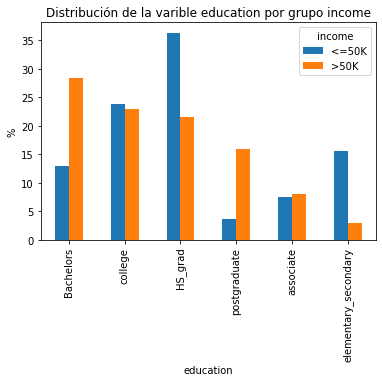

In [346]:
crostab_education.plot(kind='bar')
plt.xlabel('education')
plt.ylabel('%')
plt.title('Distribución de la variable education por grupo income')
plt.show()

In [347]:
#marital-status
crostab_marital=pd.crosstab(values=df['age'], columns=df['income'], index=df['marital-status'], 
                            aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100

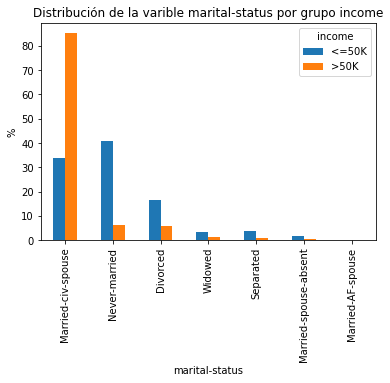

In [348]:
crostab_marital.plot(kind='bar')
plt.xlabel('marital-status')
plt.ylabel('%')
plt.title('Distribución de la variable marital-status por grupo income')
plt.show()

In [349]:
#Reagrupar categorías
df1['marital-status'] = df1['marital-status'].map({'Never-married':'Never_married','Married-civ-spouse':'married',
                                                 'Married-spouse-absent':'married', 'Married-AF-spouse': 'married',
                                                 'Separated':'Separated', 'Divorced':'Separated', 'Widowed':'Separated',
                                            })

In [350]:
#marital-status reagrupada
crostab_marital=pd.crosstab(values=df1['age'], columns=df1['income'], index=df1['marital-status'], 
                            aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_marital

income,<=50K,>50K
marital-status,,
married,35.300171,85.938615
Separated,23.843123,7.806924
Never_married,40.856706,6.254461


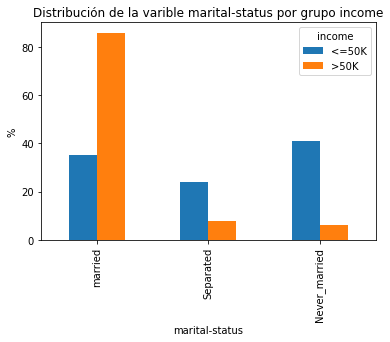

In [351]:
crostab_marital.plot(kind='bar')
plt.xlabel('marital-status')
plt.ylabel('%')
plt.title('Distribución de la variable marital-status por grupo income')
plt.show()

In [352]:
#occupation
crostab_occupation=pd.crosstab(values=df['age'], columns=df['income'], index=df['occupation'], 
                               aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100

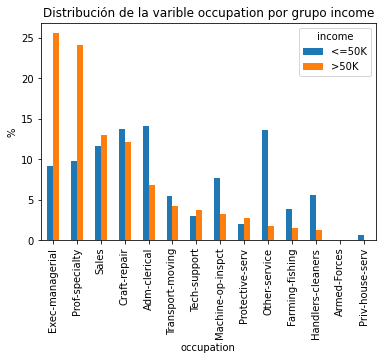

In [353]:
crostab_occupation.plot(kind='bar')
plt.xlabel('occupation')
plt.ylabel('%')
plt.title('Distribución de la varible occupation por grupo income')
plt.show()

In [354]:
#Reagrupar categorías
df1['occupation'] = df1['occupation'].map({'Machine-op-inspct':'Machine_op_inspct','Farming-fishing':'Farming_fishing',
                                         'Protective-serv':'Other_service','Priv-house-serv':'Other_service',
                                         'Handlers-cleaners':'Other_service','Armed-Forces':'Other_service',
                                         'Other-service':'Other_service', 'Prof-specialty':'Prof_specialty',
                                         'Craft-repair':'Craft_repair', 'Adm-clerical':'Adm_clerical',
                                         'Exec-managerial': 'Exec_managerial','Tech-support':'Tech_support',
                                         'Sales':'Sales','Transport-moving':'Transport_moving'})

In [355]:
#occupation reagrupada
crostab_occupation=pd.crosstab(values=df1['age'], columns=df1['income'], index=df1['occupation'], 
                            aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_occupation

income,<=50K,>50K
occupation,,
Exec_managerial,9.163874,25.579943
Prof_specialty,9.713647,24.125625
Sales,11.621685,12.981799
Craft_repair,13.714941,12.089579
Adm_clerical,14.064797,6.745182
Other_service,21.846887,5.754818
Transport_moving,5.403657,4.264811
Tech_support,2.966426,3.667024
Machine_op_inspct,7.658611,3.256602


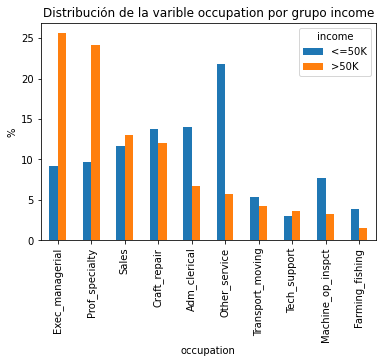

In [356]:
crostab_occupation.plot(kind='bar')
plt.xlabel('occupation')
plt.ylabel('%')
plt.title('Distribución de la varible occupation por grupo income')
plt.show()

In [357]:
#relationship 
crostab_relationship=pd.crosstab(values=df['age'], columns=df['income'], index=df['relationship'], 
                            aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_relationship

income,<=50K,>50K
relationship,,
Husband,29.867114,75.901142
Not-in-family,30.793203,10.956460
Wife,3.160463,9.064954
Unmarried,13.188687,2.694504
Own-child,19.171518,0.936831
Other-relative,3.819016,0.446110


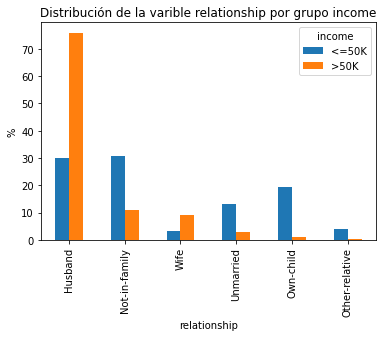

In [44]:
crostab_relationship.plot(kind='bar')
plt.xlabel('relationship')
plt.ylabel('%')
plt.title('Distribución de la varible relationship por grupo income')
plt.show()

In [358]:
#race
crostab_race=pd.crosstab(values=df['age'], columns=df['income'], index=df['race'], 
                            aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_race

income,<=50K,>50K
race,,
White,84.365261,91.068879
Black,10.860234,4.764454
Asian-Pac-Islander,2.745928,3.292291
Amer-Indian-Eskimo,1.123067,0.472877
Other,0.905509,0.401499


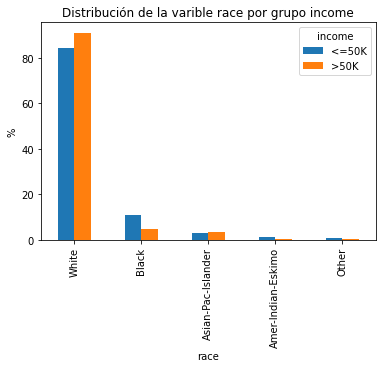

In [106]:
crostab_race.plot(kind='bar')
plt.xlabel('race')
plt.ylabel('%')
plt.title('Distribución de la varible race por grupo income')
plt.show()

In [359]:
#sex
crostab_sex=pd.crosstab(values=df['age'], columns=df['income'], index=df['sex'], 
                            aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_sex

income,<=50K,>50K
sex,,
Male,61.704004,85.108851
Female,38.295996,14.891149


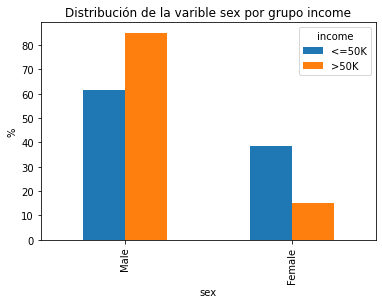

In [360]:
crostab_sex.plot(kind='bar')
plt.xlabel('sex')
plt.ylabel('%')
plt.title('Distribución de la varible sex por grupo income')
plt.show()

In [361]:
#native-country
crostab_native=pd.crosstab(values=df['age'], columns=df['income'], index=df['native-country'], 
                            aggfunc=lambda x: len(x), normalize='columns').sort_values('>50K', ascending=False)*100
crostab_native

income,<=50K,>50K
native-country,,
United-States,90.680308,93.219129
Philippines,0.585053,0.749465
India,0.249897,0.553176
Canada,0.302816,0.535332
Germany,0.396895,0.517488
England,0.211678,0.419343
Mexico,2.516611,0.419343
China,0.226377,0.321199
Cuba,0.291057,0.303355


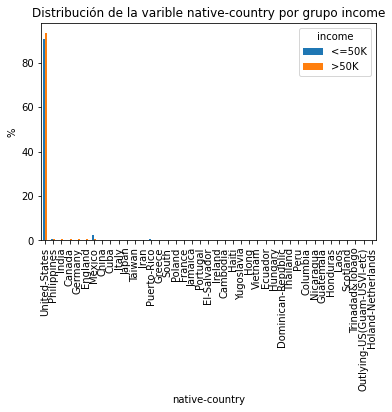

In [362]:
crostab_native.plot(kind='bar')
plt.xlabel('native-country')
plt.ylabel('%')
plt.title('Distribución de la varible native-country por grupo income')
plt.show()

In [363]:
#Tablación cruzada marital_status y relationship

crostab_marital_relation=pd.crosstab(values=df1['age'], columns=df1['marital-status'], index=df1['relationship'], 
                            aggfunc=lambda x: len(x), normalize='columns')*100
crostab_marital_relation

marital-status,Never_married,Separated,married
relationship,,,
Husband,0.000000,0.000000,86.260918
Not-in-family,45.835046,52.420701,1.391007
Other-relative,5.617208,3.338898,1.058274
Own-child,40.169886,6.444073,0.845695
Unmarried,8.377860,37.796327,0.780997
Wife,0.000000,0.000000,9.663108


De las variables categóricas, de acuerdo a las variaciones de sus distribuciones segmentadas por income. 
Las variables que permiten encontrar diferencias entre los dos grupos de ingresos son education, marital_status,
occupation y sex. Se excluye a relationship porque esta correlacionado con el compartamiento de marital_status.
La variable race no se contempla porque no se observa que las distribuciones sean significativamente diferentes
en los grupos de ingresos.

In [364]:
#data de variables de interés para el modelo
df2=df1[["capital_gain","education","marital-status","occupation","sex","income"]]
df2.head()

,capital_gain,education,marital-status,occupation,sex,income
0,-0.146733,elementary_secondary,Never_married,Machine_op_inspct,Male,<=50K
1,-0.146733,HS_grad,married,Farming_fishing,Male,<=50K
2,-0.146733,associate,married,Other_service,Male,>50K
3,0.877467,college,married,Machine_op_inspct,Male,>50K
4,-0.146733,elementary_secondary,Never_married,Other_service,Male,<=50K


In [365]:
#categorizar variables
object_columns = [x for x in df2.select_dtypes(include='object').columns if x != 'capital-gain']
for objcol in object_columns:
    df2[objcol] = df2[objcol].astype('category')

In [366]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   capital_gain    45222 non-null  float64 
 1   education       45222 non-null  category
 2   marital-status  45222 non-null  category
 3   occupation      45222 non-null  category
 4   sex             45222 non-null  category
 5   income          45222 non-null  category
dtypes: category(5), float64(1)
memory usage: 575.1 KB


In [367]:
post_df = df2.copy()

In [368]:
#dummies education
dummies = pd.get_dummies(post_df['education'])
post_df = pd.concat([post_df, dummies], axis=1)
post_df.drop(columns=['education', 'HS_grad'], inplace=True)

In [369]:
#dummies marital-status
dummies = pd.get_dummies(post_df['marital-status'])
post_df = pd.concat([post_df, dummies], axis=1)
post_df.drop(columns=['marital-status', 'married'], inplace=True)


In [370]:
#dummies occupation
dummies = pd.get_dummies(post_df['occupation'])
post_df = pd.concat([post_df, dummies], axis=1)
post_df.drop(columns=['occupation', 'Exec_managerial'], inplace=True)

In [371]:
#Binarización de la variables sex e income
post_df['sex'] = post_df['sex'].map({'Male': 1, 'Female': 0})
post_df['income'] = post_df['income'].map({'<=50K':0, '>50K':1})

In [372]:
post_df.head()

,capital_gain,sex,income,Bachelors,associate,college,elementary_secondary,postgraduate,Never_married,Separated,Adm_clerical,Craft_repair,Farming_fishing,Machine_op_inspct,Other_service,Prof_specialty,Sales,Tech_support,Transport_moving
0,-0.146733,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,-0.146733,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,-0.146733,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.877467,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.146733,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0


### 3.2 Regresión logística

Se entrena el modelo de regresión logística y se hallan los métricas de rendimiento. El modelo tiene una exactitud (accurancy) del 0.8350 es decir, el 83.5% de las personas fueron clasificadas correctamente según sus ingresos anuales. Pero la sensibilidad es menor (recall), su capacidad de clasificar correctamente las personas con ingresos >50K cuando realmente reportan esos ingresos es del 54.6%. Lo cual sugiere el planteamiento del modelo de regresión logística con el balanceo de la muestra, ya que el 75% de las personas tienen ingresos <=50K, para comparar el rendimiento entre los modelos con o sin balanceo. Para efecto de demostrar el uso y análisis de las métricas de Fairness, se utilizará el modelo de regresión logística sin balanceo.   

In [373]:
# Separación de X e Y.

X = post_df.loc[:, post_df.columns != 'income']
y = post_df.loc[:, post_df.columns == 'income']

In [374]:
# Datos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=908)

In [375]:
lr=LogisticRegressionCV(solver='liblinear', cv=10, random_state=908)
lr.fit(X_train, np.ravel(y_train))

LogisticRegressionCV(cv=10, random_state=908, solver='liblinear')

Accuracy

In [376]:
#Métricas modelo base

y_pred_proba = lr.predict_proba(X_test)[:,1]
y_pred = y_pred_proba >= 0.5

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Accuracy: 0.8350469872857933
Recall: 0.5465532676812892
F1: 0.6207422470767666


Evaluación de las clasificaciones del modelo a través de las métricas Fairness

In [ ]:
#Se clasifica la variable sexo en grupo privilegiado los hombres y no privilegiado las mujeres para establecer, 
#si el modelo de regresión logística tiende a favorecer más a los hombres dentro del grupo de ingresos >50K que a
#las mujeres. Adicionalmente, se define la función get_aif_metrics, para obtener la métricas fairness; diferencia de paridad
#estadística y la diferencia de tasa de error entre el grupo privilegiado y no privilegiado con las predicciones
#halladas con la muestra de entrenamiento. 

In [377]:
# definir grupos privilegiados (1=hombres) y no privilegiados (0=mujeres).
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [112]:
def get_aif_metrics(attr, df, label_names):

    privileged_groups = [{attr: 1}]
    unprivileged_groups = [{attr: 0}]

    attributes_params = dict(protected_attribute_names=[attr], label_names=label_names)
    dt = BinaryLabelDataset(df=df, **attributes_params, favorable_label=1, unfavorable_label=0)

    metric = BinaryLabelDatasetMetric(dt,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)

    return metric, dt

In [378]:
y_train_pred_proba = lr.predict_proba(X_train)[:,1]
y_train_pred = y_train_pred_proba >= 0.5

In [379]:
df_pred = X_train.copy()
df_pred['income'] = y_train_pred

In [ ]:
#Métrica: Diferencia de paridad estadística. Es la diferencia entre las tasas de verdaderos positivos (TP/P) entre el grupo
#no privilegiado ser mujer y el privilegiado ser hombre.

In [380]:
metric_sex_pred, pred_aifdf = get_aif_metrics('sex', df_pred, ['income'])
print(f'Pred Statistical Parity Difference (sex): {metric_sex_pred.mean_difference()}')

Pred Statistical Parity Difference (sex): -0.20193230114825897


De acuerdo al indicador de diferencia de paridad estadística hay más propabilidades de que los hombres sean clasificados con ingresos >50K que las mujeres. Dos de cada diez hombres más que las mujeres. 

In [381]:
df_train = X_train.copy()
df_train['income'] = y_train

In [382]:
metric_sex_train, train_aifdf = get_aif_metrics('sex', df_train, ['income'])

ClassificationMetric

In [383]:
orig_vs_pred = ClassificationMetric(train_aifdf, pred_aifdf,
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)

In [ ]:
#Métrica: Error rate difference -Diferencias de las tasa de error entre el grupo sin privilegio y con privilegio 
# ERR=(FP+FN)/P+N

In [384]:
print(f'Error rate difference (unprivileged error rate - privileged error rate)= {orig_vs_pred.error_rate_difference()}\n')

Error rate difference (unprivileged error rate - privileged error rate)= -0.11814789448924967



In [385]:
print(f'False negative rate for privileged groups = {orig_vs_pred.false_negative_rate(privileged=True)}')
print(f'False negative rate for unprivileged groups = {orig_vs_pred.false_negative_rate(privileged=False)}')
print(f'False negative rate ratio = {orig_vs_pred.false_negative_rate_ratio()}\n')

print(f'False positive rate for privileged groups = {orig_vs_pred.false_positive_rate(privileged=True)}')
print(f'False positive rate for unprivileged groups = {orig_vs_pred.false_positive_rate(privileged=False)}')
print(f'False positive rate ratio = {orig_vs_pred.false_positive_rate_ratio()}')

False negative rate for privileged groups = 0.4076458223857068
False negative rate for unprivileged groups = 0.6130690161527166
False negative rate ratio = 1.503925669015301

False positive rate for privileged groups = 0.10620368156825245
False positive rate for unprivileged groups = 0.013274758857797726
False positive rate ratio = 0.12499339629075495


El modelo genera mayores errores de estimación de clasificación en el grupo privilegiado debido a la tasa de falsos positivos. 

### 3.3 Aplicación Algoritmo EqOddsPostProcessing sobre las predicciones del modelo de regresión logística con los datos de testeo y cálculo de la métricas fairness

Este algoritmo EqOddsPostProcessing se aplica para lograr la paridad en la tasa predictiva, es decir, la probabilidad de observación positiva de la variable objetivo entra las personas a las que se predice el resultado positivo es independiente de las subpoblaciones hombres y mujeres. 

In [386]:
#predicciones para los datos de prueba
y_pred_proba = lr.predict_proba(X_test)[:,1]
y_pred = y_pred_proba >= 0.5

In [387]:
# Dataframe test con predicciones
df_test_pred = X_test.copy()
df_test_pred['income'] = y_pred

# Dataframe test con etiquetas
df_test = X_test.copy()
df_test['income'] = y_test

In [388]:
#Aplicación del algoritmo EqOddsPostProcessing
from aif360.algorithms.postprocessing.eq_odds_postprocessing import EqOddsPostprocessing

In [389]:
metric_sex_test_pred, test_pred_aifdf = get_aif_metrics('sex', df_test_pred, ['income'])
_, test_aifdf = get_aif_metrics('sex', df_test, ['income'])

In [390]:
roc = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
                                 privileged_groups=privileged_groups,
                           seed = 103)
roc.fit(test_aifdf, test_pred_aifdf)

In [391]:
df = roc.predict(test_pred_aifdf)

In [392]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]


metric = BinaryLabelDatasetMetric(df,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

In [393]:
cm_pred_test_post = ClassificationMetric(test_aifdf, df,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

In [394]:
cm_pred_test_post.equal_opportunity_difference()

0.014295397649381592

In [ ]:
#METRICAS FAIRNESS CON LA IMPLEMENTACIÓN DEL ALGORITMO DE EqOddsPostprocessing

In [ ]:
#Métrica: Diferencia de paridad estadística. 

In [395]:
MetricTextExplainer(metric).mean_difference()

'Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.07092331682428081'

ClassificationMetric

In [396]:
orig_vs_pred = ClassificationMetric(test_aifdf, df,
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)

In [ ]:
#Métrica: Error rate difference -Diferencia de tasa de error - con la implementación del algoritmo de EqOddsPostprocessing

In [397]:
print(f'Error rate difference (unprivileged error rate - privileged error rate)= {orig_vs_pred.error_rate_difference()}\n')

Error rate difference (unprivileged error rate - privileged error rate)= -0.10846233891467483



In [398]:
print(f'False negative rate for privileged groups = {orig_vs_pred.false_negative_rate(privileged=True)}')
print(f'False negative rate for unprivileged groups = {orig_vs_pred.false_negative_rate(privileged=False)}')
print(f'False negative rate ratio = {orig_vs_pred.false_negative_rate_ratio()}\n')

print(f'False positive rate for privileged groups = {orig_vs_pred.false_positive_rate(privileged=True)}')
print(f'False positive rate for unprivileged groups = {orig_vs_pred.false_positive_rate(privileged=False)}')
print(f'False positive rate ratio = {orig_vs_pred.false_positive_rate_ratio()}')

False negative rate for privileged groups = 0.5843279709392839
False negative rate for unprivileged groups = 0.5700325732899023
False negative rate ratio = 0.9755353185876037

False positive rate for privileged groups = 0.07777255639097744
False positive rate for unprivileged groups = 0.07397260273972603
False positive rate ratio = 0.9511401729917643


### 3.4 Métricas Fairness obtenidas con las predicciones realizadas con el modelo de regresión logística con los datos de testeo

In [ ]:
#Métrica: Diferencia de paridad estadística

In [399]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [400]:
attributes_params = dict(protected_attribute_names=['sex'], label_names=['income'])
dt_test_pred = BinaryLabelDataset(df=df_test_pred, **attributes_params)

In [138]:
metric_sex_train = BinaryLabelDatasetMetric(dt_test_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [401]:
MetricTextExplainer(metric_sex_train).mean_difference()

'Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.1975830166220287'

ClassificationMetric

In [404]:
metric_sex_pred, pred_aifdf = get_aif_metrics('sex', df_test_pred, ['income'])

In [405]:
metric_sex_test, test_aifdf = get_aif_metrics('sex', df_test, ['income'])

In [406]:
orig_vs_pred = ClassificationMetric(test_aifdf, pred_aifdf,
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)

In [ ]:
#Métrica: Error rate difference -Diferencia de tasa de error

In [407]:
print(f'Error rate difference (unprivileged error rate - privileged error rate)= {orig_vs_pred.error_rate_difference()}\n')

Error rate difference (unprivileged error rate - privileged error rate)= -0.12272237632705618



In [408]:
print(f'False negative rate for privileged groups = {orig_vs_pred.false_negative_rate(privileged=True)}')
print(f'False negative rate for unprivileged groups = {orig_vs_pred.false_negative_rate(privileged=False)}')
print(f'False negative rate ratio = {orig_vs_pred.false_negative_rate_ratio()}\n')

print(f'False positive rate for privileged groups = {orig_vs_pred.false_positive_rate(privileged=True)}')
print(f'False positive rate for unprivileged groups = {orig_vs_pred.false_positive_rate(privileged=False)}')
print(f'False positive rate ratio = {orig_vs_pred.false_positive_rate_ratio()}')

False negative rate for privileged groups = 0.4276076803321225
False negative rate for unprivileged groups = 0.6156351791530945
False negative rate ratio = 1.4397196483349672

False positive rate for privileged groups = 0.10244360902255639
False positive rate for unprivileged groups = 0.016829745596868884
False positive rate ratio = 0.16428302123916047


### 4. Conclusiones

-De acuerdo al indicador de diferencia de paridad estadística -0.2019, hay más propabilidades de que los hombres sean clasificados con el modelo de regresión en ingresos >50K que las mujeres. Dos de cada diez hombres más que las mujeres.
Por otra parte, las diferencias entre las tasas de error de clasificación de los grupos mujeres (sin privilegio) y hombres(con privilegio) es de -0.1181, lo que indica que la tasa de error de clasificación en el grupo hombres es mayor que en el de las mujeres, producto de una mayor tasa de falsos positivos en el grupo hombres (10.62%) que en el de las mujeres (1.33%). Por otra parte, las tasas de falsos negativos es mayor en el grupo mujeres (61.31%) que en el de hombres (40.76%).

-Con el algoritmo de mitigación de sesgo EqOddsPostProcessing aplicado a las predicciones del modelo de regresión logística, se logra igualar la probalidad de pertenecer a la clase privilegiada (>50K) dado que se pertenece al grupo hombre o mujer, teniendo en cuenta que el indicador de la diferencia de paridad estadística es igual a -0.07092.

-Se reduce la diferencia de la tasa error de clasificación del modelo por efecto de la mitigación de sesgo aplicado. Se pasa de -0.1227 a -0.1085.